In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import os 
import numpy as np

In [2]:
# Path to the data folders
RAW_DATA_FOLDER = '../data/RAW/'
CLEAN_DATA_FOLDER = '../data/CLEAN/'

## First Dataset: CMU Movies

In [4]:
# Load the movie metadata
CMU_movie_metadata = pd.read_csv(RAW_DATA_FOLDER+'CMU_Movies_Dataset/movie.metadata.tsv', delimiter='\t', header=None)
CMU_movie_metadata.columns = ['wikipedia_movie_ID', 'freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
CMU_movie_metadata.set_index('wikipedia_movie_ID', inplace=True) # Use the wikipedia_movie_ID as the index
CMU_movie_metadata.head(10)

# Load the character metadata
CMU_char_metadata = pd.read_csv(RAW_DATA_FOLDER+'CMU_Movies_Dataset/character.metadata.tsv', sep='\t', header=None)
CMU_char_metadata.columns = ['wikipedia_movie_ID', 'freebase_movie_ID', 'movie_release_date', 'character_name', 'actor_DOB', 'actor_gender', 'actor_height_meters', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'freebase_character_actor_map_ID', 'freebase_character_ID', 'freebase_actor_ID']
CMU_char_metadata.set_index('wikipedia_movie_ID', inplace=True)

# Load the plot summaries
CMU_plot_summary = pd.read_csv(RAW_DATA_FOLDER+'CMU_Movies_Dataset/plot_summaries.txt', sep='\t', header=None)
CMU_plot_summary.columns = ['wikipedia_movie_ID', 'plot_summary']
CMU_plot_summary.set_index('wikipedia_movie_ID', inplace=True)

# Make the intersection between CMU plot and metadata
CMU_merge =pd.merge(CMU_movie_metadata,CMU_plot_summary,how="inner",on=["wikipedia_movie_ID"])




# Initial analysis

In [5]:
def initial_inspection(dataset):
    print("Is the new index unique ? Answer : {}".format(dataset.index.is_unique)) # Ensures that we chose a good new index 
    print("Are the titles unique? Answer: {}".format(dataset.movie_name.is_unique))
    duplicated_movies = dataset.movie_name[dataset.movie_name.duplicated()]
    print("There are {} movies that have same titles.".format(len(duplicated_movies)))
    print("It corresponds to {:%}".format(len(duplicated_movies)/len(dataset)))


initial_inspection(CMU_movie_metadata)
print(" ")
initial_inspection(CMU_merge)

Is the new index unique ? Answer : True
Are the titles unique? Answer: False
There are 6263 movies that have same titles.
It corresponds to 7.662006%
 
Is the new index unique ? Answer : True
Are the titles unique? Answer: False
There are 2290 movies that have same titles.
It corresponds to 5.426026%


In [18]:
CMU_movie_metadata[CMU_movie_metadata.movie_name == "The Bridge"]

,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
wikipedia_movie_ID,,,,,,,,
7460227,/m/0kv80y,The Bridge,2006-09-01,NaN,69.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
4953051,/m/0cwvf3,The Bridge,2006,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0jtdp"": ""Documentary""}"
10195064,/m/02q4tmc,The Bridge,1992,NaN,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama"", ""/m/0219x_"": ""Indie""}"
16771910,/m/04y5ksr,The Bridge,1959-10-22,NaN,96.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/082fr"": ""West Germany"", ""/m/0345h"": ""Germ...","{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}"


Upon investigation, it seems that it corresponds to still different movies. Those can be remake or just totally different movies. The index has thus to remain the wikipedia_movie_ID. 

The intersection of countries for which we have the summaries and metadata has to be taken into account, instead of only the ones that we have the summary and/or metadata. We don't care about character movies metadata. 

In [39]:
print("Number of movies that we have the summary {}".format(CMU_plot_summary.shape[0]))
print("Number of movies that we have the characters infos {}".format(CMU_char_metadata.shape[0]))
print("Number of movies that we have the metadata {}".format(CMU_movie_metadata.shape[0]))
print("Number of movies that we have the metadata and summary {}".format(len(CMU_merge)))

Number of movies that we have the summary 42303
Number of movies that we have the characters infos 450669
Number of movies that we have the metadata 81741
Number of movies that we have the metadata and summary 42204


In [6]:
print("Summary data columns: {}".format(CMU_plot_summary.columns))
print("Character data columns: {}".format(CMU_char_metadata.columns))
print("Movie metadata columns: {}".format(CMU_movie_metadata.columns))

Summary data columns: Index(['plot_summary'], dtype='object')
Character data columns: Index(['freebase_movie_ID', 'movie_release_date', 'character_name',
       'actor_DOB', 'actor_gender', 'actor_height_meters', 'actor_ethnicity',
       'actor_name', 'actor_age_at_movie_release',
       'freebase_character_actor_map_ID', 'freebase_character_ID',
       'freebase_actor_ID'],
      dtype='object')
Movie metadata columns: Index(['freebase_movie_ID', 'movie_name', 'movie_release_date',
       'movie_box_office_revenue', 'movie_runtime', 'movie_languages',
       'movie_countries', 'movie_genres'],
      dtype='object')


In [7]:
print("Different types of the data summary {}".format(CMU_plot_summary.dtypes))
print("Different types of the data metadata characters {}".format(CMU_char_metadata.dtypes))
print("Different types of the data metadata movies {}".format(CMU_movie_metadata.dtypes))

Different types of the data summary plot_summary    object
dtype: object
Different types of the data metadata characters freebase_movie_ID                   object
movie_release_date                  object
character_name                      object
actor_DOB                           object
actor_gender                        object
actor_height_meters                float64
actor_ethnicity                     object
actor_name                          object
actor_age_at_movie_release         float64
freebase_character_actor_map_ID     object
freebase_character_ID               object
freebase_actor_ID                   object
dtype: object
Different types of the data metadata movies freebase_movie_ID            object
movie_name                   object
movie_release_date           object
movie_box_office_revenue    float64
movie_runtime               float64
movie_languages              object
movie_countries              object
movie_genres                 object
dtype: object


The release data is not a float64 as expected. Thus it indicates that processing and cleaning is needed. 

In [8]:
CMU_movie_metadata.movie_release_date

wikipedia_movie_ID
975900      2001-08-24
3196793     2000-02-16
28463795          1988
9363483           1987
261236            1983
               ...    
35228177    2011-03-19
34980460    2011-01-21
9971909     1972-09-22
913762      1992-05-21
12476867          2002
Name: movie_release_date, Length: 81741, dtype: object

Upon inspection it appears that not all release dates follow the same pattern. Indeed, either there is the specific date [year/month/day] or only the year. Investigation has to be conducted to whethever we can only use the data that have the year or if we use only the ones that have the full date. Note that we don't know to which country this release date corresponds to. Comparisons with kaggle dataset will be performed to ensure the veracity of the data and fill all dates that just have the year, as well as all missing values.  

Investigation of NaN values 

In [42]:
print("Number of Nan values in plot {}".format(CMU_plot_summary.plot_summary.isna().sum()))
print("Number of Nan values in metadata {}".format(CMU_movie_metadata.movie_release_date.isna().sum()))
print("Number of Nan values in merge {}".format(CMU_merge.movie_release_date.isna().sum()))

Number of Nan values in plot 0
Number of Nan values in metadata 6902
Number of Nan values in merge 2618


In [43]:
CMU_movie_metadata.movie_release_date

wikipedia_movie_ID
975900      2001-08-24
3196793     2000-02-16
28463795          1988
9363483           1987
261236            1983
               ...    
35228177    2011-03-19
34980460    2011-01-21
9971909     1972-09-22
913762      1992-05-21
12476867          2002
Name: movie_release_date, Length: 81741, dtype: object

In [101]:
# Define the regex pattern for YYYY-MM-DD
date_pattern = r'\d{4}-\d{2}-\d{2}'
#regex has been tried to map also just years -> issue

month_year_pattern = r"\b\d{4}-\d{2}\b(?!-\d{2})"

# Apply regex to each element in the DataFrame and keep only matching elements
matching_elements_date = CMU_merge.movie_release_date.apply(lambda x: x if isinstance(x, str) and pd.notna(x) and pd.Series([x]).str.contains(date_pattern).any() else None)

CMU_merge_date =CMU_merge[CMU_merge.movie_release_date == matching_elements_date]



In [79]:
def int_conversion(x):
    try:
        int(x)
        return x
    except ValueError:
        return None

CMU_merge_year = CMU_merge[CMU_merge.movie_release_date ==CMU_merge.movie_release_date.apply(int_conversion)]

In [84]:
print(len(CMU_merge))
print(len(CMU_merge_date)+ len(CMU_merge_year)+CMU_merge.movie_release_date.isna().sum())
print(len(CMU_merge_date)+ len(CMU_merge_year))

42204
40826
38208


In [67]:
int(CMU_merge_year.movie_release_date[18998739])

2002

In [92]:
CMU_merge.movie_release_date

wikipedia_movie_ID
975900      2001-08-24
9363483           1987
261236            1983
18998739          2002
6631279     1997-04-04
               ...    
23851782    1941-05-03
35228177    2011-03-19
34980460    2011-01-21
913762      1992-05-21
12476867          2002
Name: movie_release_date, Length: 42204, dtype: object

In [104]:
merge_date_set =set(CMU_merge_date.movie_release_date)
merge_year_set = set(CMU_merge_year.movie_release_date)
merge_set = set(CMU_merge.movie_release_date)

merge_diff = merge_set -merge_year_set -merge_date_set

In [143]:
CMU_merge["year"] = CMU_merge.movie_release_date.str[:4]

# Secondary dataset: GVD 

In [10]:
GVD_data = pd.read_csv(RAW_DATA_FOLDER+'GVD_Dataset/2023_gvdDatabase_1_0_country.csv')

# Third dataset : Kaggle movie 

In [3]:
# Load the movies metadata
Kaggle_movies_metadata = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/movies_metadata.csv')

# Load the credits
Kaggle_credits = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/credits.csv')

# Load the keywords data
Kaggle_keywords = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/keywords.csv')

# Load the ratings
Kaggle_ratings = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/ratings.csv')

# Load the links
Kaggle_links = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/links.csv')

/tmp/ipykernel_3849/830540050.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  Kaggle_movies_metadata = pd.read_csv(RAW_DATA_FOLDER+'Kaggle_Movies_Dataset/movies_metadata.csv')


In [7]:
Kaggle_movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [17]:
duplicated_kaggle = Kaggle_movies_metadata[Kaggle_movies_metadata.original_title.duplicated()]
print("Is the new index unique ? Answer : {}".format(Kaggle_movies_metadata.index.is_unique)) # Ensures that we chose a good new index 
print("Are the titles unique? Answer: {}".format(Kaggle_movies_metadata.original_title.is_unique))
print("There are {} movies that have same titles.".format(len(duplicated_kaggle)))
print("It corresponds to {:%}".format(len(duplicated_kaggle)/len(Kaggle_movies_metadata)))

Is the new index unique ? Answer : True
Are the titles unique? Answer: False
There are 2093 movies that have same titles.
It corresponds to 4.603440%


In [19]:
print("Number of Nan values in Kaggle release data {}".format(Kaggle_movies_metadata.release_date.isna().sum()))
print("Number of Nan values in title {}".format(Kaggle_movies_metadata.original_title.isna().sum()))

Number of Nan values in Kaggle release data 87
Number of Nan values in title 0


We are interested in adult to add this as a feature to our dataset, as well as release date and production countries to compare and fill nan values. We have to find a way to map kaggle to cmu. 

In [144]:
Kaggle_movies_metadata["year"] =Kaggle_movies_metadata.release_date.str[:4]
Kaggle_movies_metadata_renamed = Kaggle_movies_metadata.rename(columns={'original_title':'movie_name'})
Kaggle_movies_metadata_renamed.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'movie_name', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'year',
       'movie_release_date'],
      dtype='object')

In [147]:
len(CMU_merge)

42204

In [148]:
len(pd.merge(CMU_merge,Kaggle_movies_metadata_renamed,how="inner",on=["movie_name","year"]))

14568

# Summary analysis 

We want to use movies summaries to characterise if a movie is violent or not. This require the use of NLP that lead to a restricted count of words that can be used. 

The number of words isn't equal to the number of characters ! 

### Number of words

In [81]:
CMU_plot_summary["Number_words"] = CMU_plot_summary.plot_summary.apply(lambda x: len(x.split()))
nb_words_median = CMU_plot_summary.Number_words.median()

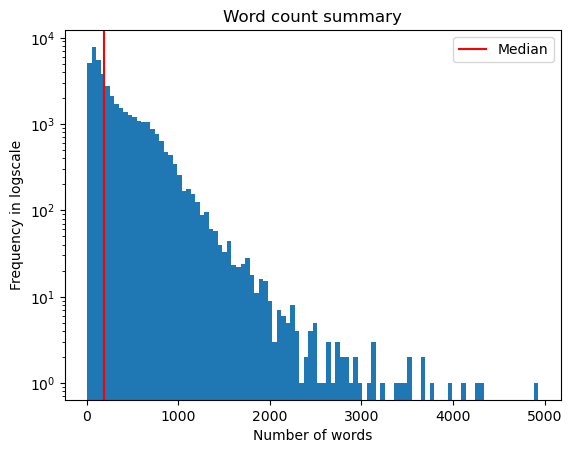

In [86]:
plt.hist(CMU_plot_summary["Number_words"], log=True,bins=100)
plt.title("Word count summary")
plt.ylabel("Frequency in logscale")
plt.axvline(x = nb_words_median, color = 'r', label = 'Median')
plt.legend()
plt.xlabel("Number of words")
plt.show()


### Number of characters 

In [ ]:
CMU_plot_summary["Character counts of summary"] =CMU_plot_summary.plot_summary.agg(len,axis="index")

/tmp/ipykernel_16699/3050376215.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  CMU_plot_summary["Word counts of summary"] =CMU_plot_summary.plot_summary.agg(len,axis="index")


In [ ]:
CMU_plot_summary["Character counts of summary"].median()

np.float64(1079.0)

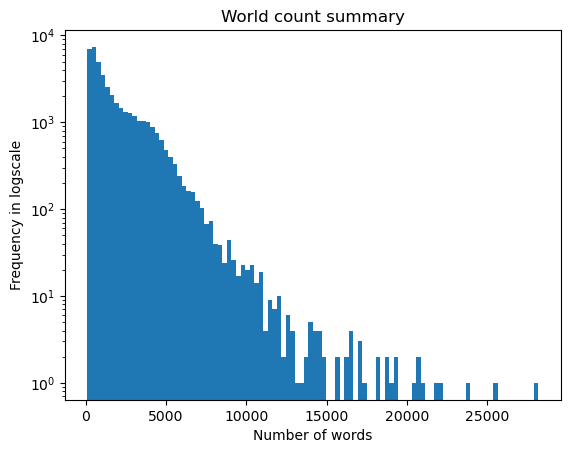

In [ ]:
plt.hist(CMU_plot_summary["Character counts of summary"], log=True,bins=100)
plt.title("Character count summary")
plt.ylabel("Frequency in logscale")
plt.xlabel("Number of characters")
plt.show()


We observe that the characters counts of the plots is skewed to the right. 

In [ ]:
CMU_plot_summary[CMU_plot_summary["Character counts of summary"] ==CMU_plot_summary["Character counts of summary"].max()]

,wikipedia_movie_ID,plot_summary,Word counts of summary
8888,22175264,The Big Beginning starts with Timmy wishing h...,28159


In [ ]:
display(CMU_plot_summary["plot_summary"][8888])

' The Big Beginning starts with Timmy wishing he was in his own movie trilogy . In the first movie, he is chased by Crocker while they both have special powers. Then, he wishes he had a second movie, where he simply throws a ring into a volcano. In the third movie, he becomes "Timmy Totter" playing "Poofer Scoop" as he chases Poof around, until Vicky appears as "Moldy Wart" and chases him, which is then interrupted by Jorgen. He zaps away Timmy\'s fairies, before cryptically warning him to stick to the shadows and not to speak his name. Timmy then falls from the sky and lands in front of his house. Timmy claims was just like any one of his other normal mornings and walks inside his house. However, his parents don\'t seem to know who he is, thinking him a street urchin. When Timmy goes to school, everyone thinks that he\'s a new kid. Growing more and more confused, Timmy shouts his name through a megaphone. At that instant, an Eliminator  bursts into the class. Timmy manages to outrun t

In [ ]:
CMU_plot_summary[CMU_plot_summary["Character counts of summary"] ==CMU_plot_summary["Character counts of summary"].min()]

,wikipedia_movie_ID,plot_summary,Word counts of summary
42168,25105934,"At Christmastime, a divorcée returns to her h...",99


# Investigation of countries representation 

Upon inspection the countries listed in movie_countries are not in a decent format and need preprocessing for further analysis. The weird characters present the same structure "/m/09c7w0" and can the pattern can thus be used to extract only the countries, rather than its length of 12 strings. It actually corresponds to  Freebase ID:name. Thus the column 'freebase_movie_ID' can be used to extract only the countries... or not, it is the freebase id of the country and not of the movie, well tried !

The meaning of movie countries isn't clear from the dataset description. It seems that it corresponds to the countries of production. 

Own test 

In [70]:
test = CMU_movie_metadata.copy()
test.movie_countries =test.movie_countries.apply(lambda x: re.sub(r'"/m/\w+":','',x)) # remove freebase id 
test.movie_countries = test.movie_countries.apply(lambda x: x.strip("{}"))# remove curly brackets
test.movie_countries = test.movie_countries.apply(lambda x: re.sub(r'^[\'"]+|[\'"]+$', '', x.strip()) )


test.movie_countries
# \w : matches any word character (basically alpha-numeric)
# + : one or more times
# /m/ : matches the character /m/ literally (case sensitive)




wikipedia_movie_ID
975900        United States of America
3196793       United States of America
28463795                        Norway
9363483                 United Kingdom
261236                         Germany
                       ...            
35228177      United States of America
34980460    Ireland",  "United Kingdom
9971909       United States of America
913762                           Japan
12476867                        Canada
Name: movie_countries, Length: 81741, dtype: object

Take Emma's function that is much more cleaner 

In [44]:
def extract_genres(text):
    # Find all matches for genre names using a regex pattern that matches quoted text after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

CMU_movie_metadata.movie_countries =CMU_movie_metadata.movie_countries.apply(extract_genres)